In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !pip install git+https://github.com/qubvel/segmentation_models

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Add, Multiply, Reshape, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import AdamW
from keras.optimizers import Adam  
from tensorflow.keras.applications.resnet50 import ResNet50
import cv2
from matplotlib import pyplot as plt

In [5]:
# Load data
x_train = np.load('/content/drive/MyDrive/np_images/x_train.npy')
y_train = np.load('/content/drive/MyDrive/np_images/y_train.npy')
x_test = np.load('/content/drive/MyDrive/np_images/x_test.npy')
y_test = np.load('/content/drive/MyDrive/np_images/y_test.npy')

# Preprocess data
x_train = tf.image.resize(x_train, size=(224, 224)) / 255.0
x_test = tf.image.resize(x_test, size=(224, 224)) / 255.0

In [6]:
# Augmentation
from keras.preprocessing.image import ImageDataGenerator

def preprocess_image(img):
    # Crop the center 80% of the image
    height, width, channels = img.shape
    crop_height = int(height * 0.8)
    crop_width = int(width * 0.8)
    start_height = int((height - crop_height) / 2)
    start_width = int((width - crop_width) / 2)
    img = img[start_height:start_height+crop_height, start_width:start_width+crop_width, :]
    
    # Apply Gaussian blur with kernel size 3
    img = cv2.GaussianBlur(img, (3, 3), 0)

    img = cv2.resize(img,(224,224))
    
    # Rescale the pixel values to [0, 1]
    img = img / 255.0
    
    return img

def create_datagen():
    return ImageDataGenerator(
        horizontal_flip=True,   # randomly flip images
        vertical_flip=True,     # randomly flip images

        preprocessing_function = preprocess_image
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train,batch_size=32)
print("Image data augmentated ...")

Image data augmentated ...


In [7]:
def spatial_attention(input_tensor):
    x = Conv2D(1, kernel_size=7, strides=1, padding='same', activation='sigmoid')(input_tensor)
    return Multiply()([input_tensor, x])



def channel_attention(input_tensor):
    x = GlobalAveragePooling2D()(input_tensor)
    x = Dense(K.int_shape(input_tensor)[-1] // 4, activation='relu')(x)
    x = Dense(K.int_shape(input_tensor)[-1], activation='relu')(x)
    x = Reshape((1, 1, K.int_shape(input_tensor)[-1]))(x)
    return Multiply()([input_tensor, x])



def resnet_sa(num_classes):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    x = base_model.output
    x = spatial_attention(x)
    x = channel_attention(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = keras.models.Model(inputs=base_model.input, outputs=output)

    for layer in base_model.layers:
        layer.trainable = False

    return model

In [8]:
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [9]:
# Split data into train and validation sets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(32)

# Create model
model = resnet_sa(num_classes=5)
model.compile(loss='categorical_crossentropy', optimizer=AdamW(lr=0.0001), metrics=['accuracy',f1])

# Train model
history = model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
92/92 [==============================] - 37s 177ms/step - loss: 1.1636 - accuracy: 0.5500 - f1: 0.1506 - val_loss: 0.9552 - val_accuracy: 0.6412 - val_f1: 0.2233
Epoch 2/100
92/92 [==============================] - 12s 128ms/step - loss: 0.9100 - accuracy: 0.6630 - f1: 0.2569 - val_loss: 0.8480 - val_accuracy: 0.7012 - val_f1: 0.2936
Epoch 3/100
92/92 [==============================] - 12s 128ms/step - loss: 0.8508 - accuracy: 0.6832 - f1: 0.2776 - val_loss: 0.8413 - val_accuracy: 0.7080 - val_f1: 0.3172
Epoch 4/100
92/92 [==============================] - 12s 129ms/step - loss: 0.8153 - accuracy: 0.6955 - f1: 0.2903 - val_loss: 0.8247 - val_accuracy: 0.7067 - val_f1: 0.3503
Epoch 5/100
92/92 [==============================] - 12s 129ms/step - loss: 0.8087 - accuracy: 0.6982 - f1: 0.3062 - val_loss: 0.8212 - val_accuracy: 0.7108 - val_f1: 0.3582
Epoch 6/100
92/92 [==============================] - 12s 132ms/step - loss: 0.7952 - accuracy: 0.7101 - f1: 0.3110 - val_loss: 0.7

In [19]:
# Evaluate model on test set
test_loss,test_acc,f1_score = model.evaluate(test_dataset)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('F1 Score:', f1_score)

23/23 [==============================] - 2s 97ms/step - loss: 1.9924 - accuracy: 0.7162 - f1: 0.4283
Test loss: 1.9923644065856934
Test accuracy: 0.7162346243858337
F1 Score: 0.428335577249527


In [20]:
import pandas as pd
hist_df = pd.DataFrame(history.history)

hist_csv_file = "/content/drive/MyDrive/Resnet50_Attention/resnet_attention_history.csv"
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [21]:
model.save('/content/drive/MyDrive/Resnet50_Attention/resnet_attention_model.h5')

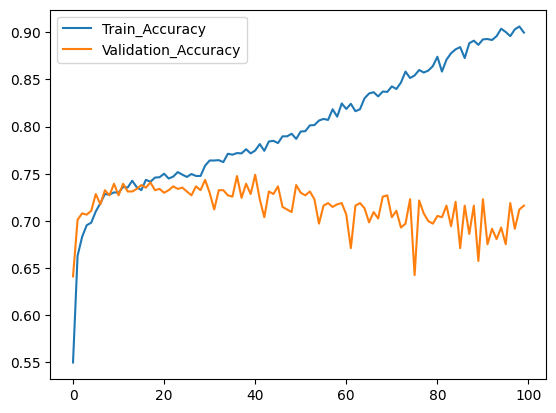

In [22]:
# Plotting graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train_Accuracy','Validation_Accuracy'])

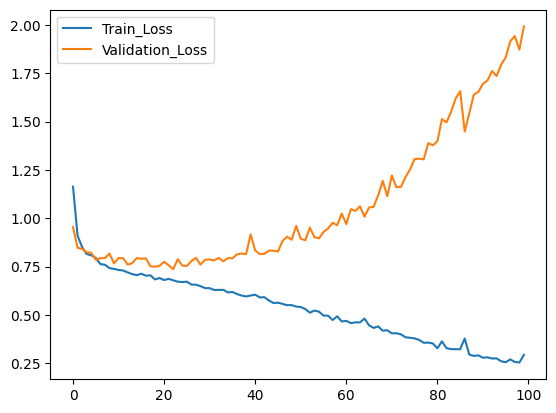

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train_Loss','Validation_Loss'])

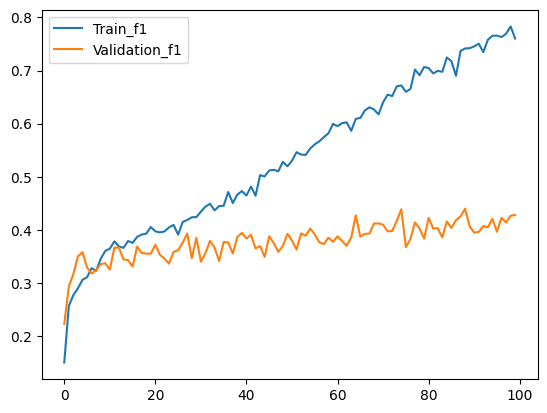

In [24]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.legend(['Train_f1','Validation_f1'])

In [39]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis = 1)
pred.shape

23/23 [==============================] - 2s 98ms/step


(733,)

In [41]:
import numpy as np

# Convert one-hot encoded format to label format
y_test = np.load('/content/drive/MyDrive/np_images/y_test.npy')
y_test = np.argmax(y_test, axis=1)

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(pred, y_test)
print(cf_matrix)


[[340  13  23   3   9]
 [  4  28  17   4   5]
 [  6  18 139  18  32]
 [  0   5  18   9  10]
 [  1   4  16   2   9]]


<Axes: >

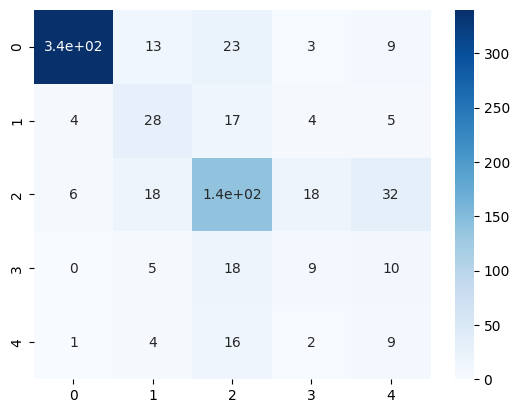

In [27]:
import seaborn as sns
sns.heatmap(cf_matrix, cmap='Blues', annot=True)